<a href="https://colab.research.google.com/github/nanaessandoh/Improving-Performance-of-CNN-using-Transfer-Learning/blob/master/Experiment%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset and Class Annotations

In [ ]:
# Colab Notebooks come along with a folder sample_data that we dont need so we go ahead to delete it
!rm -rf /content/sample_data

In [ ]:
# Download Dataset and class labels
!wget -N http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz -P Dataset/oxford_IIIT

# UnTar the Files
!tar -C Dataset/oxford_IIIT/ -xvf Dataset/oxford_IIIT/images.tar.gz

# Remove the Compressed folder
!rm Dataset/oxford_IIIT/images.tar.gz

# Prepare the Dataset

In [ ]:
# Import Packages 
from fastai.script import *
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *
import sys

In [ ]:
# Define Path to annotation and images
#path_annotation = '../content/Dataset/oxford_IIIT/annotations'
path_images = '../content/Dataset/oxford_IIIT/images'

In [ ]:
# Store the path of the images in a list
filenames = get_image_files(path_images)
# Display the total number of Images we have in the list
len(filenames)

7390

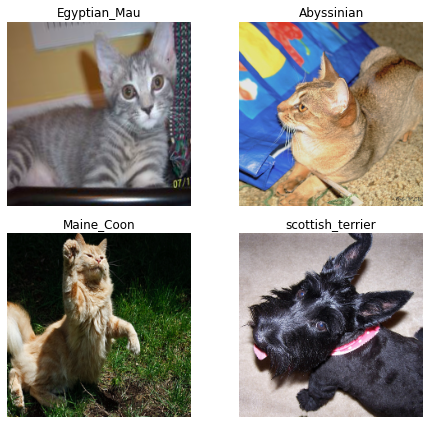

In [ ]:
# Perform preprocessing on images and prepare a batch to be passed through the network
np.random.seed(2)
path = r'/([^/]+)_\d+.jpg$'
data = ImageDataBunch.from_name_re(path_images,filenames, path, ds_tfms = get_transforms(), size = 224).normalize(imagenet_stats)
# Display Random images from DataSet
data.show_batch(rows = 2, figsize = (7,6))


In [ ]:
# Print Class Names and Length
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

# **Part 1 :** Fixed Feature Extraction on pretrained ResNet-152 using Oxford-IIIT Pets.

## Training : ResNet152
The model has a CNN backbone and a fully connected head with a single hidden layer as a classifier.

In [ ]:
learn = cnn_learner(data, models.resnet152, metrics=[accuracy,top_k_accuracy]);
learn.model;

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


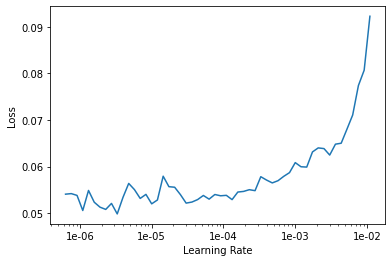

In [ ]:
# Show a graph of the learning rate of the model
learn.lr_find()
learn.recorder.plot()

In [ ]:
# Train for 10 epoch 
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.931684,0.276655,0.918133,0.996617,01:51
1,0.482469,0.297966,0.905277,0.996617,01:49
2,0.345404,0.261827,0.919486,0.998647,01:48
3,0.267620,0.242090,0.926928,0.998647,01:48
4,0.217781,0.253302,0.926252,0.996617,01:48
5,0.164178,0.223993,0.939107,0.996617,01:49
6,0.130171,0.222361,0.939107,0.998647,01:48
7,0.111968,0.187710,0.951962,0.997970,01:48
8,0.079557,0.196981,0.947903,0.998647,01:48
9,0.065583,0.202106,0.947903,0.997970,01:48


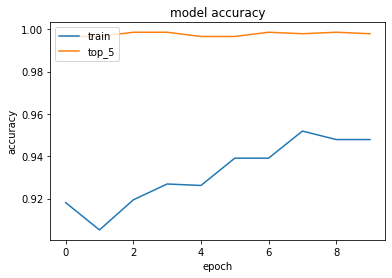

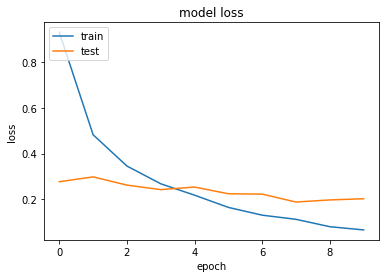

In [ ]:
import matplotlib.pyplot as plt
plt.plot([0.9181,0.9052,0.9194,0.9269,0.9262,0.9391,0.9391,0.9519,0.9479,0.9479])
plt.plot([0.9966,0.9966,0.9986,0.9986,0.9966, 0.9966,0.9986,0.9979,0.9986,0.9979])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'top_5'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot([0.9316,0.4824,0.3454,0.2676,0.2177,0.1641,0.1301,0.1119,0.07955,0.0655])
plt.plot([0.2766,0.2979,0.2618,0.2421,0.2533,0.2239,0.2223,0.1877,0.1969,0.2021])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Save the current state
learn.save("ResNet_152_model_FF", return_path=True)

PosixPath('../content/Dataset/oxford_IIIT/images/models/ResNet_152_model_FF.pth')

In [ ]:
# Export the model
learn.export('ResNet_152_model_FF.pkl')
path = learn.path
path

PosixPath('../content/Dataset/oxford_IIIT/images')

## Evaluate the results of the Training 
1. First Determine the categories in the model that are most confusing.
2. Plot the confusion matrix and determine if the model is skewed and need further training.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

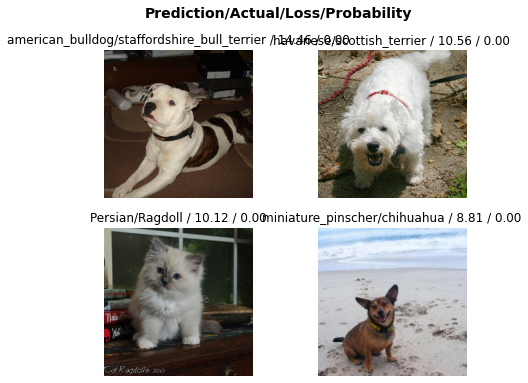

In [ ]:
# Display some images that have not be classified properly and the relevant stats
interp.plot_top_losses(4,figsize = (7,6))

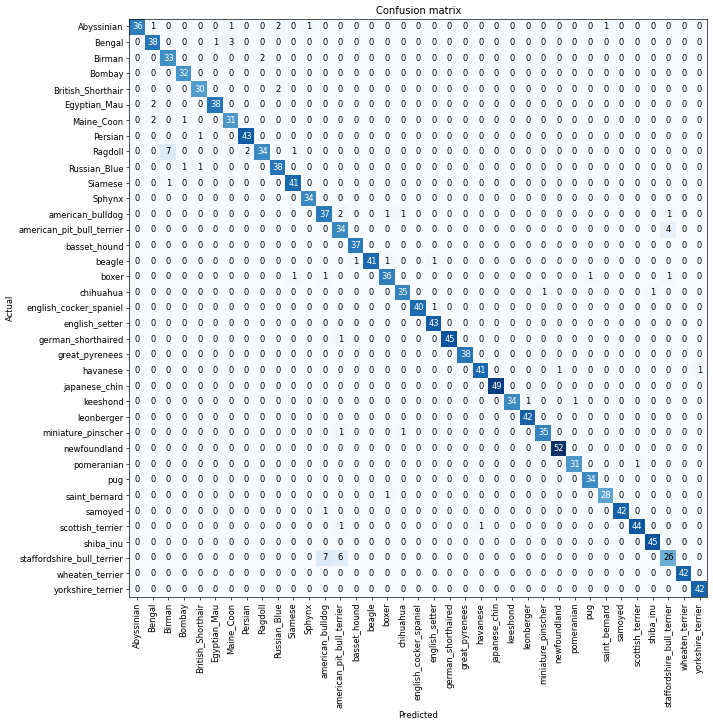

In [ ]:
# Interpret the top losses and plot the graph of the confusion matrix
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi = 60) 

In [ ]:
# Display the classes with the most confusion in prediction
interp.most_confused(min_val = 2) 

[('Ragdoll', 'Birman', 7),
 ('staffordshire_bull_terrier', 'american_bulldog', 7),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('Bengal', 'Maine_Coon', 3),
 ('Abyssinian', 'Russian_Blue', 2),
 ('Birman', 'Ragdoll', 2),
 ('British_Shorthair', 'Russian_Blue', 2),
 ('Egyptian_Mau', 'Bengal', 2),
 ('Maine_Coon', 'Bengal', 2),
 ('Ragdoll', 'Persian', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2)]

## Perform Prediciton with Model

In [ ]:
# Define the type of system that will be used for inference
defaults.device = torch.device('cpu')

In [ ]:
# Download Dog/Cat images from the web 
!wget -N https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/Chihuahua_01_K.jpg/640px-Chihuahua_01_K.jpg -P Dataset/Validation
!wget -N https://upload.wikimedia.org/wikipedia/commons/thumb/0/0c/American_Shorthair.jpg/360px-American_Shorthair.jpg -P Dataset/Validation
!wget -N https://upload.wikimedia.org/wikipedia/commons/thumb/c/c3/CPRileySnow.jpg/640px-CPRileySnow.jpg -P Dataset/Validation
!wget -N https://upload.wikimedia.org/wikipedia/commons/3/3d/LakiJustbluein.jpg -P Dataset/Validation
!wget -N https://upload.wikimedia.org/wikipedia/commons/thumb/0/03/Kufa_charta_-_borzoja.jpg/640px-Kufa_charta_-_borzoja.jpg -P Dataset/Validation
!wget -N https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Savannah_Cat_closeup.jpg/640px-Savannah_Cat_closeup.jpg-P Dataset/Validation

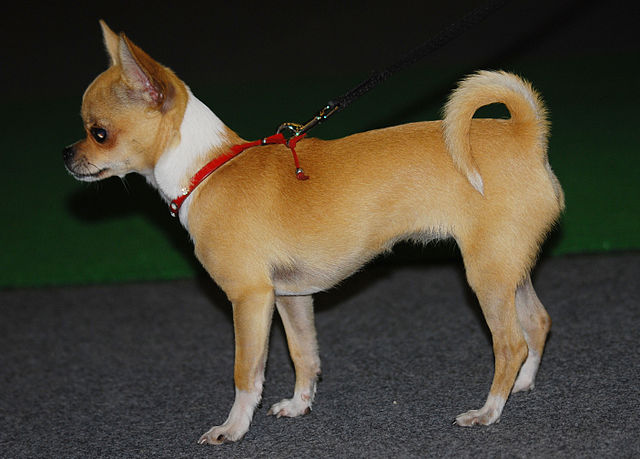

In [ ]:
# Load Images
import os
from pathlib import Path
import random
import matplotlib.pyplot as plt
path = Path('../content/Dataset/Validation')
image_filename = random.choice(list(path.glob('*.jpg')))
img3 = open_image(image_filename)
img3

In [ ]:
# Predict Image
print('----------PREDICTION RESULTS---------')
pred_class, pred_idx, outputs = learn.predict(img3)
print('Class {}  - {p:.2f}%'.format(pred_class, p=max(outputs)*100))

----------PREDICTION RESULTS---------
Class chihuahua  - 98.41%


In [ ]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
___________________________________________________

# **Part 2 :** Fixed Feature Extraction on pretrained EfficientNet-B4 using Oxford-IIIT Pets.

In [ ]:
# help link https://github.com/sdoria/EfficientNet/blob/master/Imagewoof%20from%20scratch.ipynb
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=2300ef4cadd74b30e4dd0bd668e3eca2e95b41c6aa27ad6998a783b581e97583
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch


In [ ]:
# Select an EfficientNet Model
from efficientnet_pytorch import EfficientNet
#m = EfficientNet.from_name('efficientnet-b4')
m = EfficientNet.from_pretrained('efficientnet-b4')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/checkpoints/efficientnet-b4-6ed6700e.pth



Loaded pretrained weights for efficientnet-b4


In [ ]:
# Define the optimization function
opt_func = partial(optim.Adam, betas=(0.9,0.99), eps=1e-6)

In [ ]:
# Add Fully connected layer for classification
m._fc = nn.Linear(m._fc.in_features, out_features=37, bias=True)
nn.init.kaiming_normal_(m._fc.weight);

In [ ]:
# Define the learner model
learn = (Learner(data, m, wd=1e-5, opt_func=opt_func,
         metrics=[accuracy,top_k_accuracy],
         bn_wd=False, true_wd=True,
         loss_func = LabelSmoothingCrossEntropy())
        )

In [ ]:
mixup = 0
if mixup: learn = learn.mixup(alpha=mixup)
learn = learn.to_fp16(dynamic=True)

## Training : EfficientNet-B4

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


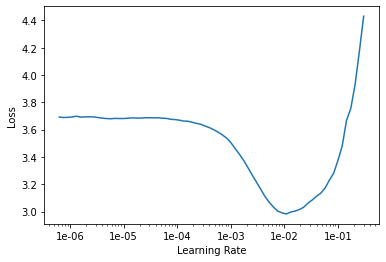

In [ ]:
# Show a graph of the learning rate of the model
learn.lr_find()
learn.recorder.plot()

In [ ]:
# Train for 80 epochs
learn.fit_one_cycle(80, 1e-2, div_factor=10, pct_start=0.3)
#learn.fit_one_cycle(15, 1e-2, div_factor=10)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.289926,1.206459,0.832206,0.978349,01:56
1,1.024067,1.040139,0.885656,0.989851,01:56
2,0.952013,1.160503,0.851150,0.977673,01:57
3,0.992509,1.250341,0.819350,0.967524,01:58
4,1.017010,1.609624,0.705007,0.928281,01:59
5,1.027232,1.565526,0.709066,0.926252,01:58
6,1.083131,2.028024,0.598106,0.862652,01:56
7,1.109496,1.859420,0.642761,0.882273,01:57
8,1.136230,3.914143,0.253721,0.497970,01:57
9,1.206817,3.251320,0.250338,0.532476,01:57


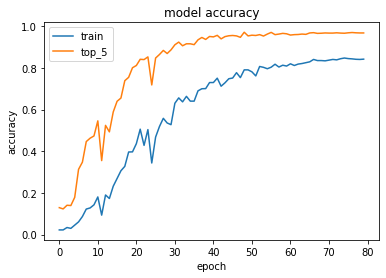

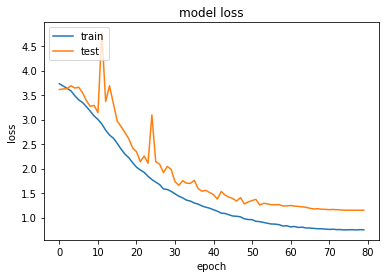

In [ ]:
import matplotlib.pyplot as plt
plt.plot([0.022327,0.022327,0.033829,0.02977,0.045332,0.060893,0.086604,0.122463,0.127876,0.14276,0.18065,0.093369,0.190122,0.173207,0.23207,0.269283,0.306495,0.32747,0.396482,0.397158,0.436401,0.506089,0.428281,0.50406,0.343708,0.4682,0.518945,0.558187,0.535859,0.52774,0.630582,0.656292,0.637348,0.663735,0.640731,0.640731,0.690122,0.700271,0.700947,0.730041,0.730041,0.751015,0.712449,0.728687,0.748309,0.751691,0.777402,0.753721,0.790934,0.790934,0.781461,0.76184,0.807172,0.803112,0.796346,0.803789,0.817997,0.804465,0.813261,0.809202,0.820027,0.811908,0.818674,0.82138,0.82544,0.829499,0.841001,0.835589,0.835589,0.834235,0.837618,0.841001,0.838972,0.844384,0.847767,0.845061,0.843708,0.841678,0.841001,0.842355])
plt.plot([0.129229,0.123139,0.140731,0.139378,0.17862,0.313261,0.347767,0.446549,0.462788,0.473613,0.546008,0.35521,0.524357,0.493234,0.588633,0.640054,0.655616,0.738836,0.755074,0.801083,0.811908,0.841678,0.840325,0.85318,0.718539,0.847767,0.864682,0.884303,0.869418,0.88701,0.911367,0.924222,0.906631,0.916103,0.916103,0.912043,0.935047,0.946549,0.937077,0.951286,0.949256,0.956698,0.939784,0.950609,0.954668,0.956022,0.953992,0.947226,0.971583,0.953992,0.957375,0.956022,0.960081,0.953315,0.962788,0.970907,0.960081,0.962788,0.96617,0.964141,0.958051,0.960081,0.960758,0.962788,0.961434,0.9682,0.969553,0.96617,0.966847,0.9682,0.967524,0.967524,0.968877,0.967524,0.966847,0.968877,0.97023,0.968877,0.9682,0.9682])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'top_5'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot([3.73011,3.682853,3.635329,3.585313,3.486049,3.401319,3.348073,3.263294,3.171067,3.072192,3.001927,2.909513,2.783031,2.683572,2.619429,2.514742,2.396825,2.293942,2.221833,2.11935,2.027772,1.969117,1.9215,1.84081,1.774771,1.722128,1.671999,1.583493,1.571627,1.533776,1.483355,1.434933,1.400324,1.353913,1.3355,1.295525,1.274418,1.23494,1.210017,1.189267,1.157511,1.128446,1.08874,1.082425,1.055172,1.030426,1.024895,1.013257,0.973077,0.958884,0.955412,0.92263,0.915667,0.898983,0.881701,0.867538,0.864972,0.853704,0.82696,0.831387,0.807791,0.81698,0.796448,0.80329,0.786505,0.785203,0.777862,0.770766,0.769854,0.763228,0.757051,0.760813,0.752844,0.752873,0.746569,0.749157,0.75135,0.746822,0.751438,0.749693])
plt.plot([3.612881,3.624011,3.629527,3.690585,3.642418,3.659202,3.548775,3.383648,3.269185,3.289116,3.140287,4.781971,3.367035,3.690323,3.326338,2.966261,2.859353,2.732516,2.608844,2.42011,2.34375,2.140597,2.256845,2.10623,3.094429,2.139901,2.089017,1.916629,2.042992,1.981385,1.731864,1.656736,1.75151,1.701028,1.696538,1.758573,1.591175,1.536328,1.554389,1.509109,1.465823,1.377142,1.531956,1.456703,1.417052,1.385658,1.336484,1.407198,1.275898,1.318591,1.346646,1.370158,1.254463,1.289412,1.279411,1.260286,1.261111,1.262727,1.236784,1.235719,1.244931,1.234323,1.226144,1.217284,1.20785,1.188385,1.174289,1.17988,1.16874,1.1668,1.159772,1.164079,1.159474,1.154663,1.148259,1.148822,1.148917,1.14858,1.148213,1.147955])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Export the model
learn.export('EfficientNet_B4_model_FF.pkl')
path = learn.path
path

PosixPath('../content/Dataset/oxford_IIIT/images')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

## Evaluating the Results of the Training

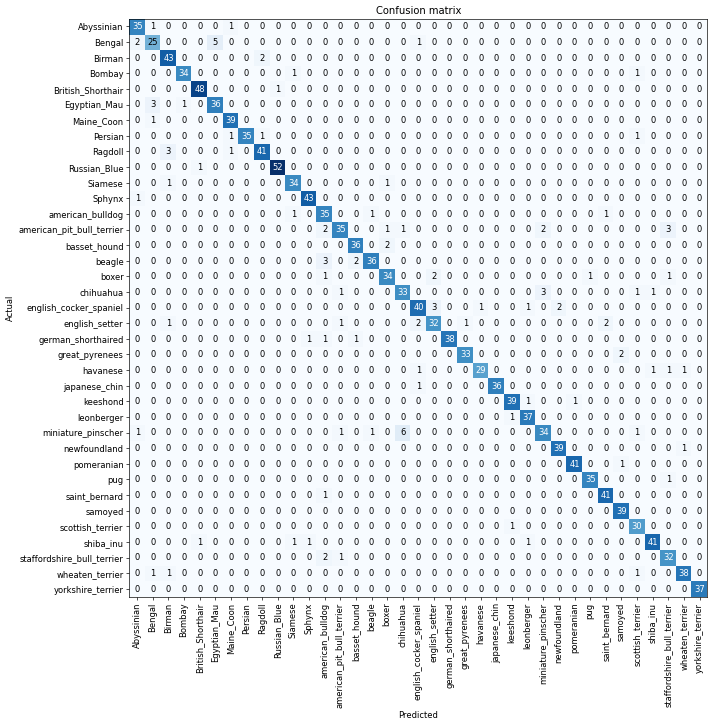

In [ ]:
# Interpret the top losses and plot the graph of the confusion matrix
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi = 60) 

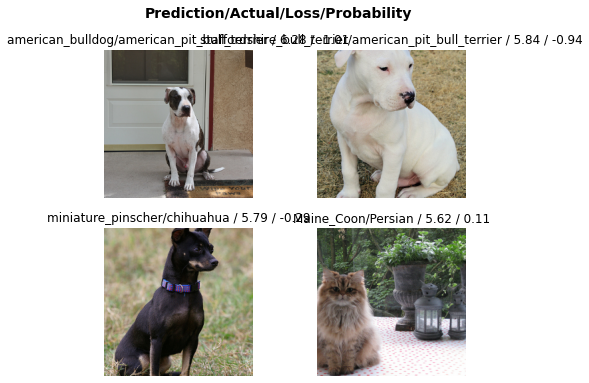

In [ ]:
# Display some images that have not be classified properly and the relevant stats
interp.plot_top_losses(4,figsize = (7,6))

## Perform Prediction with the Model

In [ ]:
# Define the type of system that will be used for inference
defaults.device = torch.device('cpu')

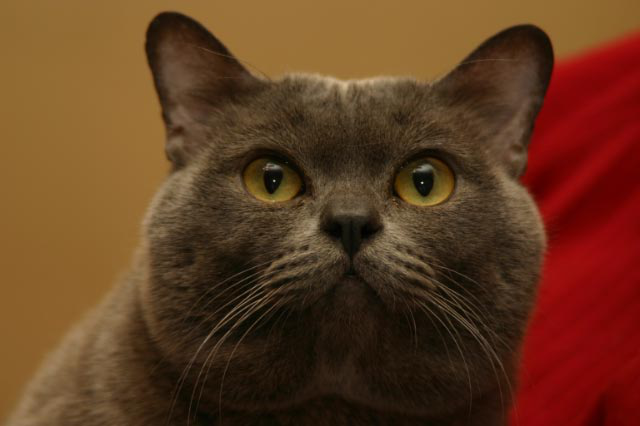

In [ ]:
# Load Images
import os
from pathlib import Path
import random
import matplotlib.pyplot as plt
path = Path('../content/Dataset/Validation')
image_filename = random.choice(list(path.glob('*.jpg')))
img3 = open_image(image_filename)
img3

In [ ]:
# Predict Image
print('----------PREDICTION RESULTS---------')
pred_class, pred_idx, outputs = learn.predict(img3)
print('Class {}  - {p:.2f}%'.format(pred_class, p=max(outputs)*10))

----------PREDICTION RESULTS---------
Class shiba_inu  - 54.18%


In [ ]:
print(learn.summary())

EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 225, 225]        0          False     
______________________________________________________________________
BatchNorm2d          [48, 112, 112]       96         True      
______________________________________________________________________
ZeroPad2d            [48, 114, 114]       0          False     
______________________________________________________________________
BatchNorm2d          [48, 112, 112]       96         True      
______________________________________________________________________
Identity             [48, 1, 1]           0          False     
______________________________________________________________________
Identity             [12, 1, 1]           0          False     
______________________________________________________________________
Identity             [48, 112, 112]       0          False     
_________________________________________________